In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from cvxopt import matrix, solvers

In [4]:
# Fetch asset data from Yahoo Finance
def get_asset_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Adj Close']
    return data

In [5]:
# Define tickers and date range
tickers = ['AAPL', 'TXNM', 'MSFT', 'JNJ', 'CL', 'NVDA']
start_date = '2020-01-01'
end_date = '2023-01-01'


In [6]:
# Fetch adjusted closing prices
data = get_asset_data(tickers, start_date, end_date)
data.dropna(inplace=True)

[*********************100%***********************]  6 of 6 completed


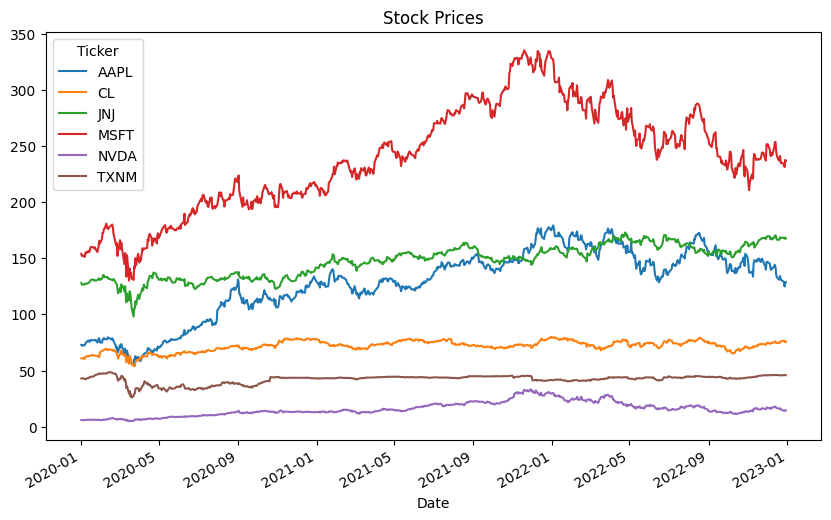

In [7]:
# Visualize stock prices
data.plot(figsize=(10,6))
plt.title("Stock Prices")
plt.show()

In [8]:
# Calculate daily returns and annualized expected returns
returns = data.pct_change().dropna()
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

In [9]:
# Markowitz Optimization Function
def markowitz_optimization(expected_returns, cov_matrix, target_return):
    n = len(expected_returns)
    P = matrix(cov_matrix.values)
    q = matrix(np.zeros((n, 1)))
    G = matrix(-np.identity(n))
    h = matrix(np.zeros((n, 1)))
    A = matrix(np.vstack((expected_returns.values, np.ones(n))))
    b = matrix([target_return, 1.0])
    sol = solvers.qp(P, q, G, h, A, b)
    if sol['status'] != 'optimal':
        print("Optimization failed with status:", sol['status'])
        return None
    weights = np.array(sol['x']).flatten()
    return weights

target_return = 0.15
optimal_weights = markowitz_optimization(expected_returns, cov_matrix, target_return)

     pcost       dcost       gap    pres   dres
 0:  2.6555e-02 -1.0038e+00  1e+00  6e-19  3e+00
 1:  2.6434e-02  5.2375e-03  2e-02  9e-17  6e-02
 2:  2.3739e-02  2.0173e-02  4e-03  8e-17  5e-03
 3:  2.2718e-02  2.2205e-02  5e-04  8e-17  2e-04
 4:  2.2543e-02  2.2499e-02  4e-05  2e-16  2e-17
 5:  2.2529e-02  2.2527e-02  2e-06  1e-16  2e-17
 6:  2.2529e-02  2.2529e-02  2e-08  1e-16  2e-17
Optimal solution found.


In [10]:
# Monte Carlo Simulation for Efficient Frontier
def monte_carlo_simulation(expected_returns, cov_matrix, num_portfolios=50000):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    n_assets = len(expected_returns)
    for i in range(num_portfolios):
        weights = np.random.rand(n_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = portfolio_return / portfolio_risk
        results[0, i] = portfolio_return
        results[1, i] = portfolio_risk
        results[2, i] = sharpe_ratio
    return results, weights_record

In [11]:
# Plot Efficient Frontier
def plot_efficient_frontier(results):
    plt.figure(figsize=(10, 6))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='.', s=1)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier')
    plt.show()

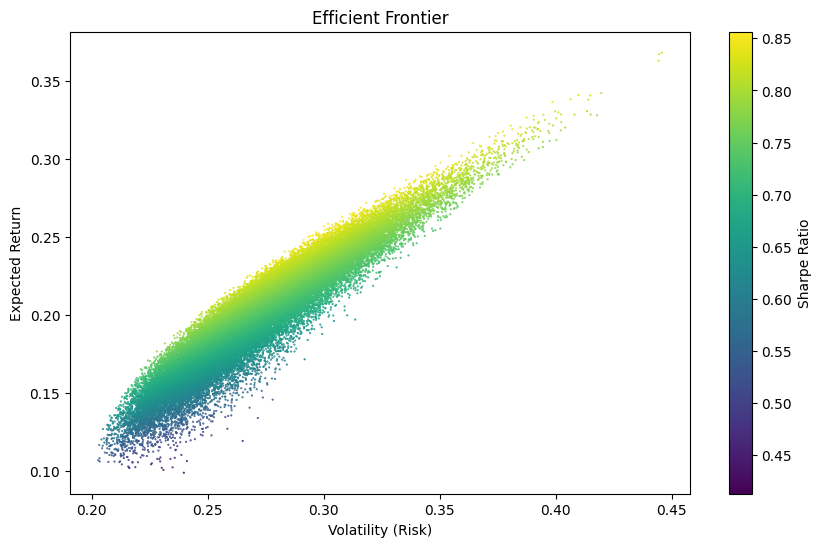

In [12]:
# Run Monte Carlo Simulation and plot Efficient Frontier
simulation_results, weights_record = monte_carlo_simulation(expected_returns, cov_matrix)
plot_efficient_frontier(simulation_results)

In [11]:
# Value at Risk (VaR) Calculation
def calculate_var(returns, weights, confidence_level=0.95):
    portfolio_returns = returns.dot(weights)
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return var

     pcost       dcost       gap    pres   dres
 0:  2.6555e-02 -1.0038e+00  1e+00  6e-17  3e+00
 1:  2.6434e-02  5.2375e-03  2e-02  1e-16  6e-02
 2:  2.3739e-02  2.0173e-02  4e-03  1e-16  5e-03
 3:  2.2718e-02  2.2205e-02  5e-04  1e-16  2e-04
 4:  2.2543e-02  2.2499e-02  4e-05  1e-16  2e-17
 5:  2.2529e-02  2.2527e-02  2e-06  1e-16  1e-17
 6:  2.2529e-02  2.2529e-02  2e-08  6e-17  1e-17
Optimal solution found.
Optimized Portfolio Allocation:
   Asset  Optimal Weight
0  AAPL    5.284586e-02
1  TXNM    2.757335e-01
2  MSFT    5.459779e-01
3   JNJ    4.175113e-07
4    CL    9.977072e-02
5  NVDA    2.567154e-02

Expected Portfolio Return: 15.00%
Expected Portfolio Risk (Volatility): 21.23%
Value at Risk (VaR) at 95% confidence level: -1.76%


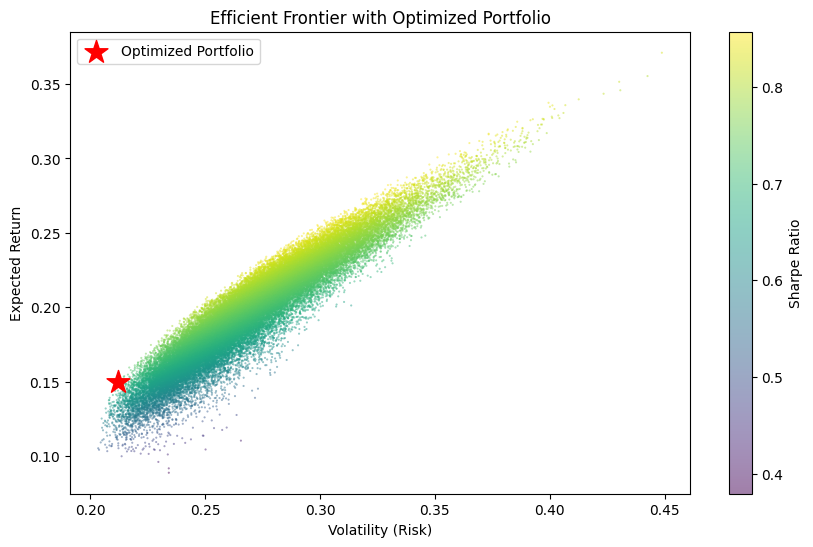

In [12]:
# Display Optimized Portfolio with Markowitz Optimization
def display_optimized_portfolio(tickers, expected_returns, cov_matrix, target_return):
    optimal_weights = markowitz_optimization(expected_returns, cov_matrix, target_return)
    if optimal_weights is None:
        print("Optimization did not find a solution.")
        return
    portfolio_df = pd.DataFrame({'Asset': tickers, 'Optimal Weight': optimal_weights})
    print("Optimized Portfolio Allocation:\n", portfolio_df)
    portfolio_return = np.dot(optimal_weights, expected_returns)
    portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
    print(f"\nExpected Portfolio Return: {portfolio_return:.2%}")
    print(f"Expected Portfolio Risk (Volatility): {portfolio_risk:.2%}")
    var = calculate_var(returns, optimal_weights)
    print(f"Value at Risk (VaR) at 95% confidence level: {var:.2%}")
    # Plot the optimized portfolio on the efficient frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(simulation_results[1, :], simulation_results[0, :], c=simulation_results[2, :], cmap='viridis', marker='.', s=1, alpha=0.5)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(portfolio_risk, portfolio_return, color='red', marker='*', s=300, label='Optimized Portfolio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier with Optimized Portfolio')
    plt.legend()
    plt.show()

display_optimized_portfolio(tickers, expected_returns, cov_matrix, target_return)

In [13]:
def calculate_cvar(returns, weights, confidence_level=0.95):
    """
    Calculate Conditional Value at Risk (CVaR) or Expected Shortfall.
    
    :param returns: DataFrame of daily returns for each asset.
    :param weights: Optimal weights of the assets in the portfolio.
    :param confidence_level: Confidence level for CVaR calculation (e.g., 0.95).
    :return: CVaR value.
    """
    # Calculate portfolio returns
    portfolio_returns = returns.dot(weights)
    
    # Sort portfolio returns in ascending order
    sorted_returns = np.sort(portfolio_returns)
    
    # Calculate the index of the VaR threshold
    var_index = int((1 - confidence_level) * len(sorted_returns))
    
    # Calculate the VaR
    var = sorted_returns[var_index]
    
    # Calculate the CVaR (average of returns below the VaR threshold)
    cvar = sorted_returns[:var_index].mean()
    
    return cvar, var

# Example: Calculate CVaR for the optimized portfolio
cvar, var = calculate_cvar(returns, optimal_weights, confidence_level=0.95)

print(f"Value at Risk (VaR) at 95% confidence level: {var:.2%}")
print(f"Conditional Value at Risk (CVaR) at 95% confidence level: {cvar:.2%}")


Value at Risk (VaR) at 95% confidence level: -1.79%
Conditional Value at Risk (CVaR) at 95% confidence level: -3.10%


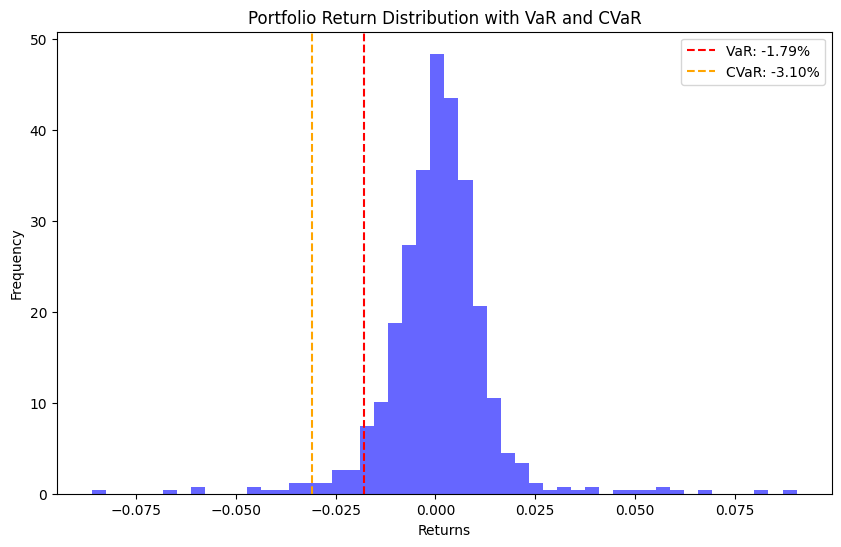

In [14]:
def plot_cvar(returns, weights, confidence_level=0.95):
    """
    Plot the distribution of portfolio returns and mark VaR and CVaR.
    
    :param returns: DataFrame of daily returns for each asset.
    :param weights: Optimal weights of the assets in the portfolio.
    :param confidence_level: Confidence level for VaR and CVaR (e.g., 0.95).
    """
    portfolio_returns = returns.dot(weights)
    sorted_returns = np.sort(portfolio_returns)
    
    var_index = int((1 - confidence_level) * len(sorted_returns))
    var = sorted_returns[var_index]
    cvar = sorted_returns[:var_index].mean()
    
    plt.figure(figsize=(10, 6))
    plt.hist(portfolio_returns, bins=50, density=True, alpha=0.6, color='blue')
    
    # Mark VaR and CVaR
    plt.axvline(x=var, color='red', linestyle='--', label=f'VaR: {var:.2%}')
    plt.axvline(x=cvar, color='orange', linestyle='--', label=f'CVaR: {cvar:.2%}')
    
    plt.title('Portfolio Return Distribution with VaR and CVaR')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot CVaR for the optimized portfolio
plot_cvar(returns, optimal_weights)

In [15]:
def find_best_portfolio(results, weights_record):
    """
    Find the portfolio with the maximum Sharpe ratio.
    
    :param results: Array containing the simulation results (returns, risks, Sharpe ratios).
    :param weights_record: List of portfolio weights for each simulation.
    :return: Dictionary with the best portfolio weights, return, risk, and Sharpe ratio.
    """
    max_sharpe_idx = np.argmax(results[2])  # Index of portfolio with max Sharpe ratio
    max_sharpe_weights = weights_record[max_sharpe_idx]
    
    return {
        'weights': max_sharpe_weights,
        'return': results[0, max_sharpe_idx],
        'risk': results[1, max_sharpe_idx],
        'sharpe_ratio': results[2, max_sharpe_idx]
    }

# Find the best portfolio from the simulation results
best_portfolio = find_best_portfolio(simulation_results, weights_record)

print("Best Portfolio Weights:", dict(zip(tickers, best_portfolio['weights'])))
print(f"Expected Return: {best_portfolio['return']:.2%}")
print(f"Risk (Volatility): {best_portfolio['risk']:.2%}")
print(f"Sharpe Ratio: {best_portfolio['sharpe_ratio']:.2f}")

Best Portfolio Weights: {'AAPL': 0.08390494321439558, 'TXNM': 0.1400683847259894, 'MSFT': 0.3278414219054433, 'JNJ': 0.010419333475321268, 'CL': 0.4340080151511538, 'NVDA': 0.003757901527696532}
Expected Return: 27.26%
Risk (Volatility): 31.79%
Sharpe Ratio: 0.86


In [17]:
# Black-Litterman Model
def black_litterman_model(expected_market_returns, cov_matrix, P, Q, tau=0.025):
    scaled_cov_matrix = tau * cov_matrix
    omega = np.dot(np.dot(P, scaled_cov_matrix), P.T)
    inv_term = np.linalg.inv(scaled_cov_matrix + np.dot(np.dot(P.T, np.linalg.inv(omega)), P))
    bl_returns = np.dot(inv_term, (np.dot(tau, np.dot(np.linalg.inv(cov_matrix), expected_market_returns)) + 
                                   np.dot(np.dot(P.T, np.linalg.inv(omega)), Q)))
    return bl_returns

# Market Returns and Covariance Matrix
market_returns = data.pct_change().mean()
cov_matrix = data.pct_change().cov()

# Black-Litterman Views
P = np.array([[1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])
Q = np.array([0.02, 0.01])  # Views on AAPL and MSFT

# Calculate Black-Litterman Adjusted Returns
bl_returns = black_litterman_model(market_returns.values, cov_matrix.values, P, Q)
bl_returns_series = pd.Series(bl_returns, index=data.columns)
print("Black-Litterman Adjusted Expected Returns:\n", bl_returns_series)

Black-Litterman Adjusted Expected Returns:
 Ticker
AAPL        0.020001
CL      12779.417729
JNJ         0.010000
MSFT   -15299.255165
NVDA     7896.877173
TXNM    -5160.327438
dtype: float64


In [16]:
# Apply Scenarios for Scenario Analysis
def apply_scenarios(returns, scenarios):
    scenario_impact = {}
    for scenario, impact in scenarios.items():
        adjusted_returns = returns + impact
        scenario_impact[scenario] = adjusted_returns.mean() * 252
    return scenario_impact

# Analyze Scenarios
def analyze_scenarios(scenarios, optimal_weights, returns):
    scenario_impact = apply_scenarios(returns, scenarios)
    for scenario, adjusted_return in scenario_impact.items():
        portfolio_return = np.dot(optimal_weights, adjusted_return)
        portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov() * 252, optimal_weights)))
        print(f"\nScenario: {scenario}")
        print(f"Adjusted Expected Return: {portfolio_return:.2%}")
        print(f"Portfolio Risk (Volatility): {portfolio_risk:.2%}")

In [18]:
# Run Scenario Analysis and Display Results
target_return = 0.15
optimal_weights = markowitz_optimization(bl_returns_series, cov_matrix, target_return)
scenarios = {'Downturn': -0.10, 'Neutral': 0.00, 'Boom': 0.10}
analyze_scenarios(scenarios, optimal_weights, returns)

     pcost       dcost       gap    pres   dres
 0:  1.4072e-04 -1.0009e+00  1e+00  4e-13  3e+00
 1:  1.4069e-04 -1.0002e-02  1e-02  6e-13  3e-02
 2:  1.3798e-04 -8.9739e-05  2e-04  1e-13  7e-04
 3:  9.9848e-05  5.3070e-05  5e-05  6e-13  7e-05
 4:  8.5084e-05  7.6641e-05  8e-06  4e-13  7e-20
 5:  8.2852e-05  8.2134e-05  7e-07  1e-13  7e-20
 6:  8.2425e-05  8.2368e-05  6e-08  7e-14  6e-20
Optimal solution found.

Scenario: Downturn
Adjusted Expected Return: -2509.13%
Portfolio Risk (Volatility): 20.38%

Scenario: Neutral
Adjusted Expected Return: 10.87%
Portfolio Risk (Volatility): 20.38%

Scenario: Boom
Adjusted Expected Return: 2530.87%
Portfolio Risk (Volatility): 20.38%
